In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2

In [2]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fer2013.csv')

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data.shape

(35887, 3)

In [5]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [6]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [8]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

In [9]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [10]:
from keras.utils import to_categorical
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [11]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [12]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [13]:
from keras import models

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [16]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=15,
                    batch_size=64)

Epoch 1/30
449/449 [==============================] - 3s 6ms/step - loss: 0.2641 - accuracy: 0.3266 - val_loss: 1.5296 - val_accuracy: 0.4129
Epoch 2/30
449/449 [==============================] - 3s 6ms/step - loss: 0.2227 - accuracy: 0.4450 - val_loss: 1.4845 - val_accuracy: 0.4511
Epoch 3/30
449/449 [==============================] - 3s 6ms/step - loss: 0.2035 - accuracy: 0.4917 - val_loss: 1.3329 - val_accuracy: 0.5026
Epoch 4/30
449/449 [==============================] - 3s 6ms/step - loss: 0.1907 - accuracy: 0.5278 - val_loss: 1.2830 - val_accuracy: 0.5283
Epoch 5/30
449/449 [==============================] - 3s 6ms/step - loss: 0.1806 - accuracy: 0.5558 - val_loss: 1.2854 - val_accuracy: 0.5157
Epoch 6/30
449/449 [==============================] - 3s 6ms/step - loss: 0.1722 - accuracy: 0.5756 - val_loss: 1.2527 - val_accuracy: 0.5405
Epoch 7/30
449/449 [==============================] - 3s 6ms/step - loss: 0.1632 - accuracy: 0.6002 - val_loss: 1.2695 - val_accuracy: 0.5394
Epoch 

In [17]:
 test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 0s 3ms/step - loss: 3.0956 - accuracy: 0.5456
test caccuracy: 0.5455558896064758


In [18]:
pred_test_labels = model.predict(test_images)

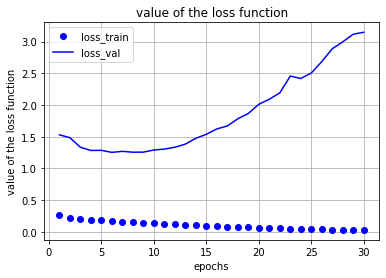

In [21]:
import matplotlib.pyplot as plt
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

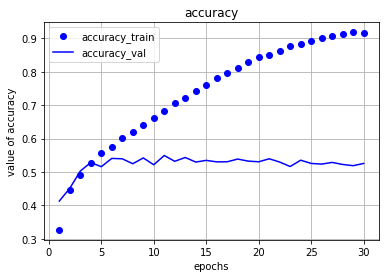

In [22]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [23]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number])
    axs[1].grid()
    
    plt.show()

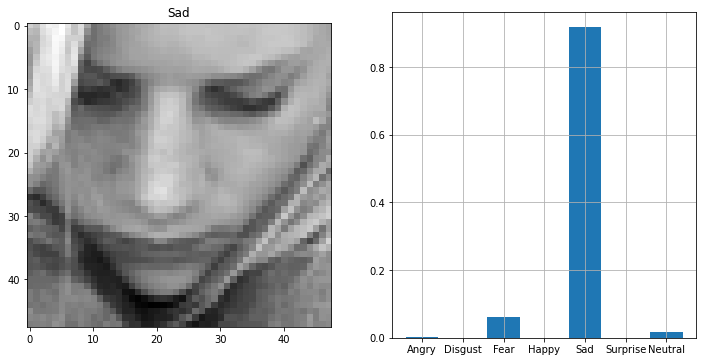

In [24]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 26)

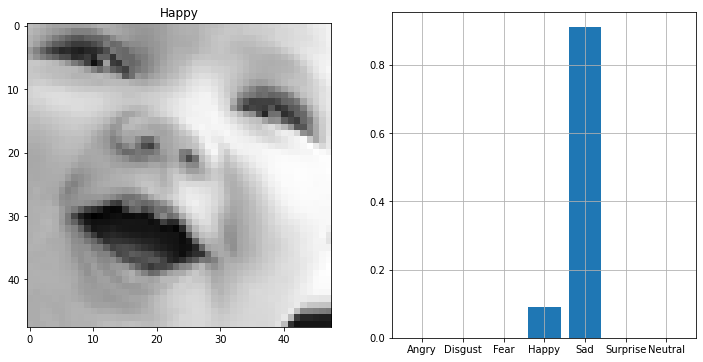

In [25]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 10)

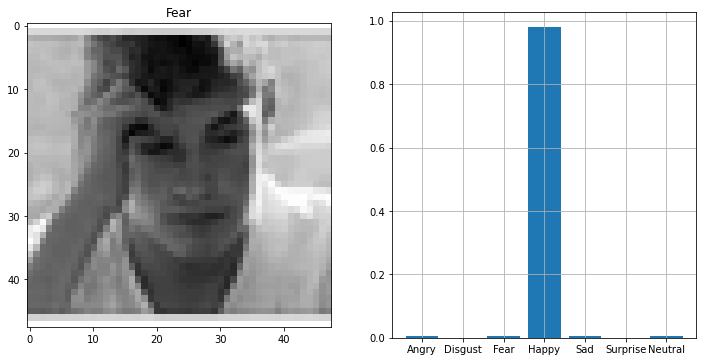

In [26]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 8)

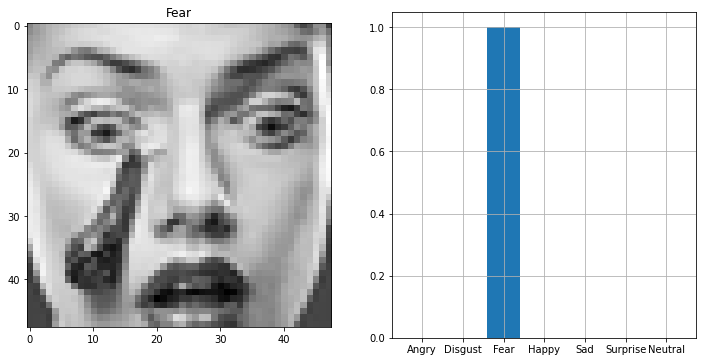

In [27]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 15)

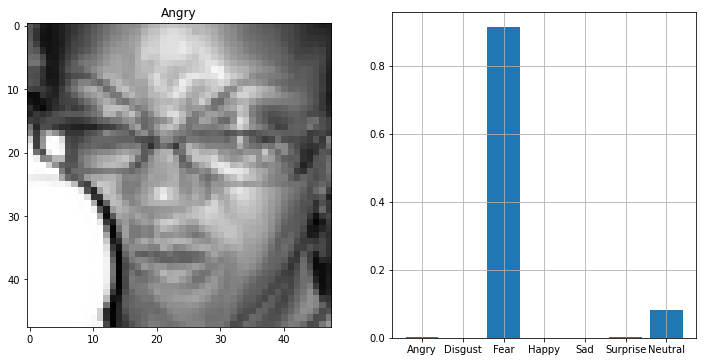

In [28]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 122)

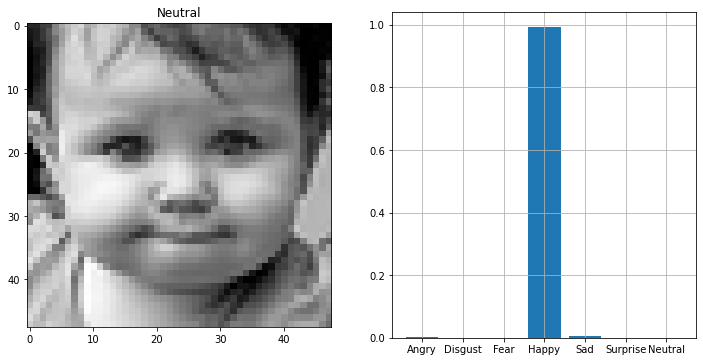

In [29]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 125)

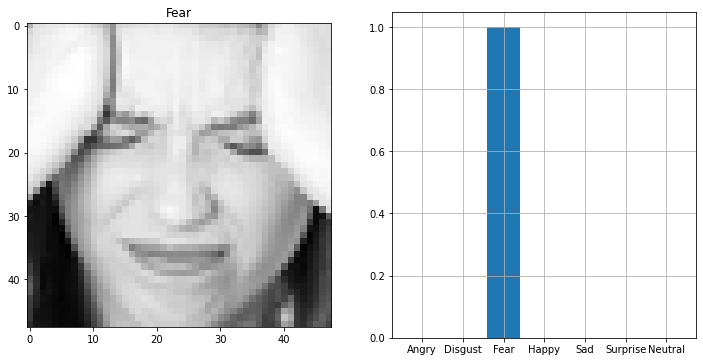

In [30]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 115)

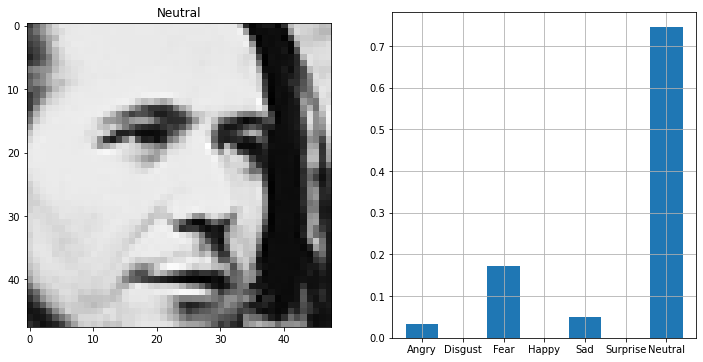

In [31]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 145)